# Daisyworld: A simple climate/biosphere feedback model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Functions

def fw(area_white, area_black, Q, L, Tlat):
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black
   
    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset
    
    Tlat = (Q*L*(1-alb_planetary)-I0+beta_coef*Tp)/(b+beta_coef)

    # Local temperatures
    Tw = S*L*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tlat 

    # Determine birth rates
    if (Tw >= T_min and Tw <= T_max and (area_white) >= 0.01): 
        beta_white = 1 - 4*np.power(T_ideal - Tw, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_white = 0
        
    return area_white*(area_ground*beta_white - gamma)


def fb(area_white, area_black, Q, L, Tlat):
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  

    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset
    
    Tlat = (Q*L*(1-alb_planetary)-I0+beta_coef*Tp)/(b+beta_coef)

    # Local temperatures
    Tb = S*L*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tlat 

    # Determine birth rates
    if (Tb >= T_min and Tb <= T_max and (area_black) >= 0.01): 
        beta_black = 1 - 4*np.power(T_ideal - Tb, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_black = 0
        
    return area_black*(area_ground*beta_black - gamma)


# Runge-kutta method
# https://math.stackexchange.com/questions/721076/help-with-using-the-runge-kutta-4th-order-method-on-a-system-of-2-first-order-od
def rk4(area_white, area_black, Q, L, Tlat, h):  
    k0 = h*fw(area_white, area_black, Q, L, Tlat)
    l0 = h*fb(area_white, area_black, Q, L, Tlat)         
    k1 = h*fw(area_white+k0/2, area_black+l0/2, Q, L, Tlat)
    l1 = h*fb(area_white+k0/2, area_black+l0/2, Q, L, Tlat)          
    k2 = h*fw(area_white+k1/2, area_black+l1/2, Q, L, Tlat)
    l2 = h*fb(area_white+k1/2, area_black+l1/2, Q, L, Tlat)                  
    k3 = h*fw(area_white+k2, area_black+l2, Q, L, Tlat)
    l3 = h*fb(area_white+k2, area_black+l2, Q, L, Tlat)                 
    area_white_new = area_white + (1/6)*(k0+2*k1+2*k2+k3) 
    area_black_new = area_black + (1/6)*(l0+2*l1+2*l2+l3)          
    
    return  area_white_new, area_black_new

In [4]:
# Constants 
b = 2.2         # W m-2 K-1
beta_coef=16    # W m-2 K-1
Ι0 = 220#150

# Temperatures
#Kelvin_offset = 273.15
Kelvin_offset = 0 #try this now
T_min = 5 + Kelvin_offset
T_max = 40 + Kelvin_offset
T_ideal = 22.5 + Kelvin_offset

# Albedo
alb_white = 0.75
alb_black = 0.15
alb_ground = 0.25

#Area (%)
area_black = 0.01
area_white = 0.01

#Rates
gamma = 0.3 # death rate s-1

# Flux terms
S = 1366  #Solar flux constant  W m-2
sigma = 5.67032e-8 # Stefab-boltzman constant W m-2 K-4

# Flux limits and step
L_min = 0.6
L_max = 2.6
L_step = 0.025 # change the step to 0.025 or 0.05

# Latitude array
lat=np.array(np.arange(-90,91,0.5),dtype=float)

# Arrays
L = np.arange(L_min, L_max, L_step)
area_black_vec = np.zeros([len(lat),len(L)])
area_white_vec = np.zeros([len(lat),len(L)])
area_ground_vec = np.zeros([len(lat),len(L)])
Tp_vec = np.zeros([len(lat),len(L)]) # planetary temperature 
Tw_vec = np.zeros([len(lat),len(L)]) # local temperature - white
Tb_vec = np.zeros([len(lat),len(L)]) # local temperature - black
total_time = np.zeros([len(lat),len(L)]) # time that daisies need to reach the steady state

Tlat = np.zeros([len(lat),len(L)])
Q = np.zeros(len(lat))

ht = np.pi/2
delta = 0

for j in range(len(lat)):
    lat[j] = lat[j]*np.pi/180 
    Q[j] = (S/np.pi)*(np.cos(lat[j])*np.cos(delta)*np.sin(ht)+np.sin(lat[j])*np.sin(delta)*ht)

In [5]:
dt=0.1 # time-step
tol=1e-9  # tolerance
I0=220#150

area_b_old=0.01
area_w_old=0.01

area_black=0.01
area_white=0.01

for j in range(len(lat)):
    
    area_b_old=area_black
    area_w_old=area_white
    
    for i in range(len(L)):
        
        # Initial Area (%)
        area_black = max(area_b_old,0.01)
        area_white = max(area_w_old,0.01)
        area_ground = 1 - (area_black + area_white)

        # Initial time
        t=0

        # Choose an initial tolerance randomly
        darea_b_tol = 1
        darea_w_tol = 1
        area_b_old=0.0
        area_w_old=0.0
        
        while darea_w_tol > tol and darea_b_tol > tol:

            # Planetary albedo
            alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  

            # Planetary temperature
            Tp_vec[j,i] = (0.25*S*L[i]*(1-alb_planetary)-I0)/(b) + Kelvin_offset
            
            # Zonal temperature
            Tlat[j,i] = (Q[j]*L[i]*(1-alb_planetary)-I0+beta_coef*Tp_vec[j,i])/(b+beta_coef)

            # Local temperatures
            Tw_vec[j,i] = S*L[i]*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tlat[j,i] 
            Tb_vec[j,i] = S*L[i]*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tlat[j,i] 

            # Determine birth rates
            if (Tw_vec[j,i] >= T_min and Tw_vec[j,i] <= T_max and (area_white) >= 0.01):
                beta_white = 1 - 4*np.power(T_ideal - Tw_vec[j,i], 2)/(np.power(T_max - T_min, 2))
            else:
                beta_white = 0

            if (Tb_vec[j,i] >= T_min and Tb_vec[j,i] <= T_max and area_black >= 0.01):
                beta_black = 1 - 4*np.power(T_ideal - Tb_vec[j,i], 2)/(np.power(T_max - T_min, 2))
            else:
                beta_black = 0


            # New areas 
            area_white, area_black = rk4(area_white, area_black, Q[j], L[i], Tlat[j,i], dt)
            area_ground = 1 - area_white - area_black
            #print(area_white)->this is too small.
            # New tolerance
            darea_b_tol = abs(area_black - area_b_old)
            darea_w_tol = abs(area_white - area_w_old)

            # for the next iteration 
            area_b_old = area_black
            area_w_old = area_white

            # Time
            t=t+dt

            # end of while loop
        
        # Fill the arrays  
        area_white_vec[j,i] = area_white
        area_black_vec[j,i] = area_black
        area_ground_vec[j,i] = area_ground
    total_time[i] = t
    print(lat[j]*180/np.pi)
    # end of for loop
    
# end of for loop

-90.0
-89.5
-89.0
-88.50000000000001
-87.99999999999999
-87.49999999999999
-87.0
-86.5
-86.0
-85.5
-85.0
-84.5
-84.0
-83.5
-83.00000000000001
-82.49999999999999
-82.0
-81.5
-81.0
-80.49999999999999
-80.0
-79.5
-79.0
-78.49999999999999
-78.0
-77.5
-77.00000000000001
-76.5
-76.0
-75.5
-75.00000000000001
-74.5
-74.0
-73.5
-73.0
-72.5
-72.0
-71.5
-71.0
-70.5
-70.0
-69.5
-68.99999999999999
-68.5
-68.0
-67.5
-66.99999999999999
-66.5
-66.0
-65.50000000000001
-65.0
-64.5
-64.0
-63.500000000000014
-63.0
-62.49999999999999
-62.0
-61.50000000000001
-61.0
-60.5
-59.99999999999999
-59.5
-59.0
-58.5
-58.0
-57.49999999999999
-57.0
-56.5
-56.0
-55.5
-55.0
-54.49999999999999
-54.0
-53.5
-53.0
-52.5
-52.00000000000001
-51.5
-51.0
-50.5
-50.0
-49.50000000000001
-49.0
-48.5
-48.0
-47.5
-47.0
-46.49999999999999
-46.0
-45.5
-45.0
-44.5
-43.99999999999999
-43.5
-43.0
-42.5
-42.0
-41.50000000000001
-41.0
-40.5
-40.0
-39.5
-39.0
-38.50000000000001
-38.0
-37.50000000000001
-37.0
-36.5
-36.0
-35.5
-35.0
-34.4999

Text(0, 0.5, 'latitude')

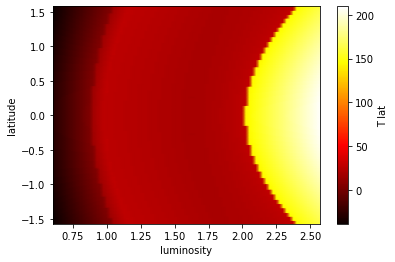

In [6]:
plt.pcolormesh(L, lat, Tlat, cmap='hot', shading='gouraud')
plt.colorbar(label='T lat')
plt.xlabel('luminosity')
plt.ylabel('latitude')

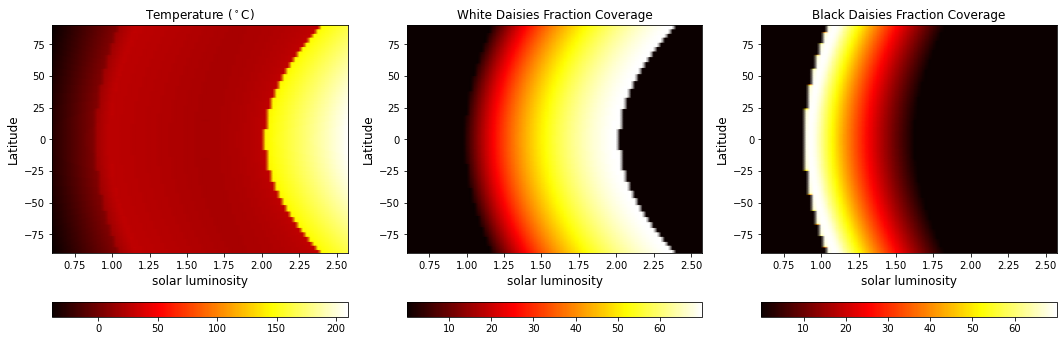

In [7]:
fig, axs = plt.subplots(1, 3,figsize=(18,6))
axs[0].set_xlabel('solar luminosity',fontsize=12)
axs[0].set_ylabel('Latitude',fontsize=12)
axs[0].set_title('Temperature ($^\circ$C)')
p1 = axs[0].pcolormesh(L, lat*180/np.pi, Tlat,cmap='hot',shading='gouraud')

axs[1].set_xlabel('solar luminosity',fontsize=12)
axs[1].set_ylabel('Latitude' ,fontsize=12)
#axs[1].set_title('Tw ($^\circ$C)') 
axs[1].set_title('White Daisies Fraction Coverage')
p2 = axs[1].pcolormesh(L, lat*180/np.pi, 100*area_white_vec,cmap='hot',shading='gouraud')
#p2 = axs[1].pcolormesh(L, lat*180/np.pi, Tw_vec,cmap='hot',shading='gouraud')

axs[2].set_xlabel('solar luminosity',fontsize=12)
axs[2].set_ylabel('Latitude' ,fontsize=12)
#axs[2].set_title('Tb ($^\circ$C)')
axs[2].set_title('Black Daisies Fraction Coverage')
p3 = axs[2].pcolormesh(L, lat*180/np.pi, 100*area_black_vec,cmap='hot',shading='gouraud')
#p3 = axs[2].pcolormesh(L, lat*180/np.pi, Tb_vec,cmap='hot',shading='gouraud')

plt.colorbar(p1,ax=axs[0],orientation='horizontal')
plt.colorbar(p2,ax=axs[1],orientation='horizontal')
plt.colorbar(p3,ax=axs[2],orientation='horizontal')

In [20]:
L[56]

2.0000000000000013

<ipython-input-39-6cb536259f35>:27: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


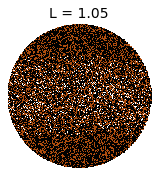

<ipython-input-39-6cb536259f35>:57: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


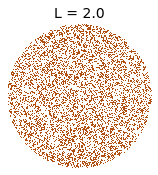

In [39]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,18]
    p_black = area_black_vec[j,18]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 1.05',fontsize=14)

plt.show()
fig.savefig('map_L_105_2.png', format='png')

#---------------------------------------------------------------
fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,56]
    p_black = area_black_vec[j,56]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 2.0',fontsize=14)

plt.show()
fig.savefig('map_L_2_2.png', format='png')


<ipython-input-40-cabec8b02282>:23: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


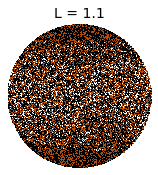

<ipython-input-40-cabec8b02282>:52: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


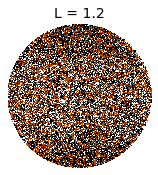

<ipython-input-40-cabec8b02282>:83: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


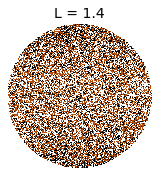

<ipython-input-40-cabec8b02282>:114: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)


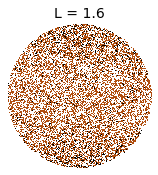

In [40]:
# ----------------------------------------------------
fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,20]
    p_black = area_black_vec[j,20]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 1.1',fontsize=14)

plt.show()
fig.savefig('map_L_11_2.png', format='png')
# ----------------------------------------------------
fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,24]
    p_black = area_black_vec[j,24]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 1.2',fontsize=14)

plt.show()
fig.savefig('map_L_12_2.png', format='png')


# ----------------------------------------------------
fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,32]
    p_black = area_black_vec[j,32]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 1.4',fontsize=14)

plt.show()
fig.savefig('map_L_14_2.png', format='png')


# ----------------------------------------------------
fig = plt.figure(figsize=(100,200))
plt.subplots_adjust(left=0.01,bottom=0.89,right=0.9,top=0.9,wspace=0.9,hspace=0)

for j in range(362):
    
    plt.subplot(362, 1, j+1)
    p_white = area_white_vec[j,40]
    p_black = area_black_vec[j,40]
    #np.random.seed(101) # this generates the same output every time.
    zvals = np.random.rand(1, 2*int(np.sqrt(181**2-(j-181)**2))) * 1  # return a sample from the “standard normal” distribution.

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'black', 'xkcd:burnt sienna'])
    bounds=[0,p_white,p_black+p_white,1] # points which are < p_white will be colored white
                                            # points which are > p_white and < p_black+p_white will be colored black
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    #plt.title('L = 1.0')
    plt.axis('off')
    
    img = plt.imshow(zvals, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    
    if j==0:
        plt.title('L = 1.6',fontsize=14)

plt.show()
fig.savefig('map_L_16_2.png', format='png')

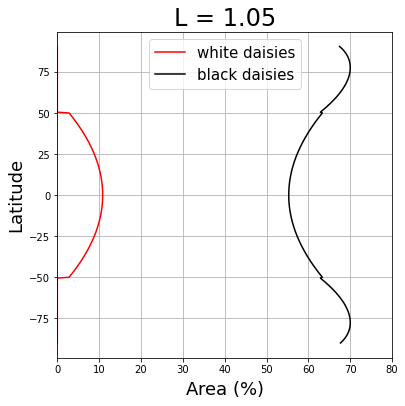

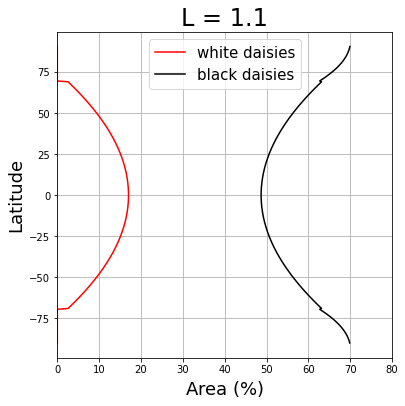

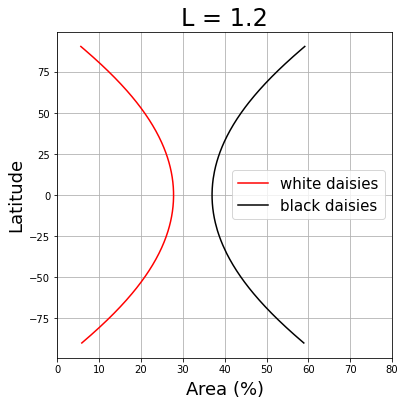

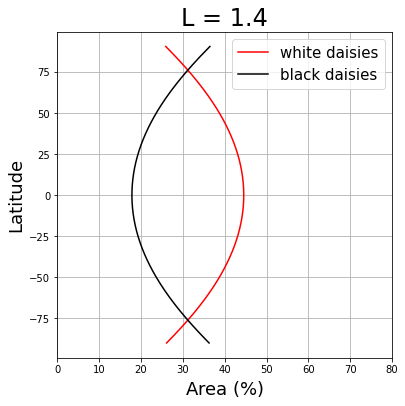

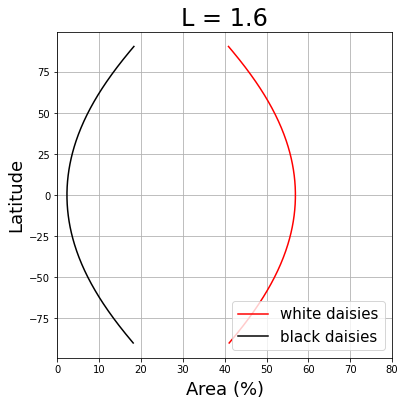

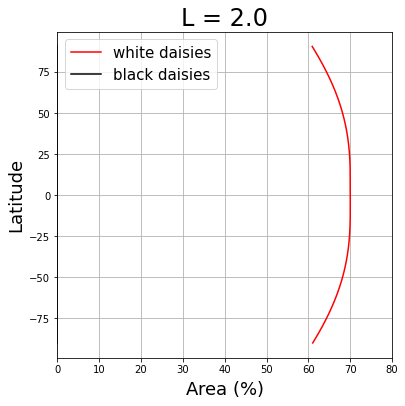

In [48]:
#temperature or area  vs latitude  should choose one luminosity
fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 1.05',fontsize=24)
plt.plot(100*area_white_vec[:,18], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,18], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=9,fontsize=15)
plt.xlim([0,80])
plt.grid()
fig.savefig('plot_L_105_2.png', format='png')

fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 1.1',fontsize=24)
plt.xlim([0,80])
plt.plot(100*area_white_vec[:,20], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,20], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=9,fontsize=15)
plt.grid()
fig.savefig('plot_L_11_2.png', format='png')


fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 1.2',fontsize=24)
plt.xlim([0,80])
plt.plot(100*area_white_vec[:,24], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,24], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=5,fontsize=15)
plt.grid()
fig.savefig('plot_L_12_2.png', format='png')

fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 1.4',fontsize=24)
plt.xlim([0,80])
plt.plot(100*area_white_vec[:,32], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,32], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=1,fontsize=15)
plt.grid()
fig.savefig('plot_L_14_2.png', format='png')

fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 1.6',fontsize=24)
plt.xlim([0,80])
plt.plot(100*area_white_vec[:,40], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,40], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=4,fontsize=15)
plt.grid()
fig.savefig('plot_L_16_2.png', format='png')

fig= plt.figure(figsize=(6,6))
plt.xlabel('Area ($\%$)',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('L = 2.0',fontsize=24)
plt.xlim([0,80])
plt.plot(100*area_white_vec[:,56], lat*180/np.pi, 'r', label='white daisies')
plt.plot(100*area_black_vec[:,56], lat*180/np.pi, 'k',label='black daisies')
plt.legend(loc=2,fontsize=15)
plt.grid()
fig.savefig('plot_L_2_2.png', format='png')
